In [1]:
from mpi4py import MPI
from manapy.ast import Variable
from manapy.base.base import Struct
from manapy.ddm import Domain
from manapy.partitions import MeshPartition
from manapy.solvers.advec.tools_utils import initialisation_gaussian_2d
import numpy as np
import time
from numba import cuda

import matplotlib.pyplot as plt

from timeit import default_timer as timer

###############
# test_time
###############

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

###############
# verify
###############
def verify(a, b):
  b = b.copy_to_host()
  plt.plot(a)
  plt.plot(b)

  #assert
  np.testing.assert_almost_equal(a, b, decimal=2, )
  plt.show()

###############
# init
###############
def init(dim, mesh_path):
  running_conf = Struct(backend="numba", signature=True, cache=True, precision="double")
  MeshPartition(mesh_path, dim=dim, conf=running_conf, periodic=[0,0,0])

  running_conf = Struct(backend="numba", signature=True, cache =True, precision="double")
  domain = Domain(dim=dim, conf=running_conf)
  ne = Variable(domain=domain)
  u  = Variable(domain=domain)
  v  = Variable(domain=domain)
  w  = Variable(domain=domain)
  
  P = Variable(domain=domain)
  Pinit = 2.0
  cells = domain.cells
  initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, cells.center, Pinit)

  u.face[:] = 2.
  v.face[:] = 0.
  w.face[:] = 0.
  
  u.interpolate_facetocell()
  v.interpolate_facetocell()
  w.interpolate_facetocell()
  return (domain, ne, u, v, w, P)

In [4]:
dim = 2
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre_hybrid.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square_larger.msh"
mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square.msh"
domain, ne, u, v, w, P = init(dim=dim, mesh_path=mesh_file)

Reading gmsh file ...
Saving partition files ...
Number of Cells: 258030
Number of Vertices: 129684
Local domain contruction ...


In [3]:
from numba import cuda

def create_var(v):
  #v = v.astype(np.float32)
  return (v, cuda.to_device(v))

host_w_c, d_w_c = create_var(ne.cell)
host_w_ghost, d_w_ghost = create_var(ne.ghost)
host_w_halo, d_w_halo = create_var(ne.halo)
host_w_node, d_w_node = create_var(ne.node)
host_cellidf, d_cellidf = create_var(ne.domain.faces.cellid)
host_nodeidf, d_nodeidf = create_var(ne.domain.faces.nodeid)
host_centergf, d_centergf = create_var(ne.domain.faces.ghostcenter)
host_halofid, d_halofid = create_var(ne.domain.faces.halofid)
host_centerc, d_centerc = create_var(ne.domain.cells.center)
host_centerh, d_centerh = create_var(ne.domain.halos.centvol)
host_vertexn, d_vertexn = create_var(ne.domain.nodes.vertex)
host_airDiamond, d_airDiamond = create_var(ne.domain.faces.airDiamond)
host_normalf, d_normalf = create_var(ne.domain.faces.normal)
host_f_1, d_f_1 = create_var(ne.domain.faces.f_1)
host_f_2, d_f_2 = create_var(ne.domain.faces.f_2)
host_f_3, d_f_3 = create_var(ne.domain.faces.f_3)
host_f_4, d_f_4 = create_var(ne.domain.faces.f_4)
host_shift, d_shift = create_var(ne.domain.cells.shift)
host_wx_face, d_wx_face = create_var(ne.gradfacex)
host_wy_face, d_wy_face = create_var(ne.gradfacey)
host_wz_face, d_wz_face = create_var(ne.gradfacez)
host_innerfaces, d_innerfaces = create_var(ne.domain._innerfaces)
host_halofaces, d_halofaces = create_var(ne.domain.halofaces)
host_dirichletfaces, d_dirichletfaces = create_var(ne.dirichletfaces)
host_neumann, d_neumann = create_var(ne.neumannfaces)
host_periodicfaces, d_periodicfaces = create_var(ne.domain.periodicboundaryfaces)


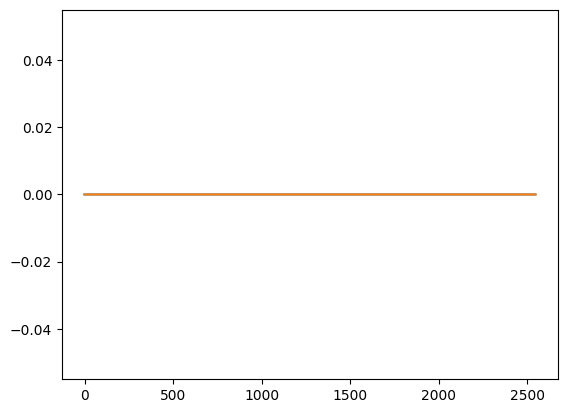

In [4]:
a = host_wx_face
b = d_wx_face.copy_to_host()
plt.plot(a)
plt.plot(b)
plt.show()

In [5]:
#The original function from functions2d.py

from numpy import  int32, float32, uint32
import numpy as np

def face_gradient_2d(w_c:'float[:]', w_ghost:'float[:]', w_halo:'float[:]', w_node:'float[:]', cellidf:'int32[:,:]', 
                     nodeidf:'int32[:,:]', centergf:'float[:,:]', halofid:'int32[:]', centerc:'float[:,:]', 
                     centerh:'float[:,:]', vertexn:'float[:,:]', airDiamond:'float[:]', normalf:'float[:,:]',
                     f_1:'float[:,:]', f_2:'float[:,:]', f_3:'float[:,:]', f_4:'float[:,:]', shift:'float[:,:]', 
                     wx_face:'float[:]', wy_face:'float[:]', wz_face:'float[:]', innerfaces:'uint32[:]', halofaces:'uint32[:]',
                     dirichletfaces:'uint32[:]', neumann:'uint32[:]', periodicfaces:'uint32[:]'):


    for i in innerfaces:
       
        c_left = cellidf[i][0]
        c_right = cellidf[i][1]
            
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = w_node[i_1]
        vi2 = w_node[i_2]
        vv1 = w_c[c_left]
        vv2 = w_c[c_right]
        
        wx_face[i] = 1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        wy_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])
    
    for i in periodicfaces:
     
        c_left = cellidf[i][0]
        c_right = cellidf[i][1]
            
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = w_node[i_1]
        vi2 = w_node[i_2]
        vv1 = w_c[c_left]
        vv2 = w_c[c_right]
        
        wx_face[i] = 1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        wy_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])
    
    for i in halofaces:
       
        c_left = cellidf[i][0]
        c_right = halofid[i]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = w_node[i_1]
        vi2 = w_node[i_2]
        vv1 = w_c[c_left]
        vv2 = w_halo[c_right]
        
        wx_face[i] = 1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        wy_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])
    
    
    for i in dirichletfaces:
       
        c_left = cellidf[i][0]
        c_right = i
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = w_node[i_1]
        vi2 = w_node[i_2]
        vv1 = w_c[c_left]
        vv2 = w_ghost[c_right]

        wx_face[i] = 1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        wy_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])
    
    
    for i in neumann:
     
        c_left = cellidf[i][0]
        c_right = i
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]
        
        vi1 = w_node[i_1]
        vi2 = w_node[i_2]
        vv1 = w_c[c_left]
        vv2 = w_ghost[c_right]

        wx_face[i] = 1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
        wy_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])




In [6]:
#? using numba jit -> backend.py
#! Using parallel=True yields poor results.
import numba

                            
numba_face_gradient_2d = numba.jit(face_gradient_2d, nopython=True, fastmath=True, parallel=False, cache=True)
def cpu_face_gradient_2d():
  numba_face_gradient_2d(
    host_w_c,
    host_w_ghost,
    host_w_halo,
    host_w_node,
    host_cellidf,
    host_nodeidf,
    host_centergf,
    host_halofid,
    host_centerc,
    host_centerh,
    host_vertexn,
    host_airDiamond,
    host_normalf,
    host_f_1,
    host_f_2,
    host_f_3,
    host_f_4,
    host_shift,
    host_wx_face,
    host_wy_face,
    host_wz_face,
    host_innerfaces,
    host_halofaces,
    host_dirichletfaces,
    host_neumann,
    host_periodicfaces,
  )


In [7]:
#time taken by cpu_numba_cell_gradient_2d

initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, domain.cells.center, 2.0)

%timeit cpu_face_gradient_2d()

58.2 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
test_time(700, cpu_face_gradient_2d)

0.06061 ms


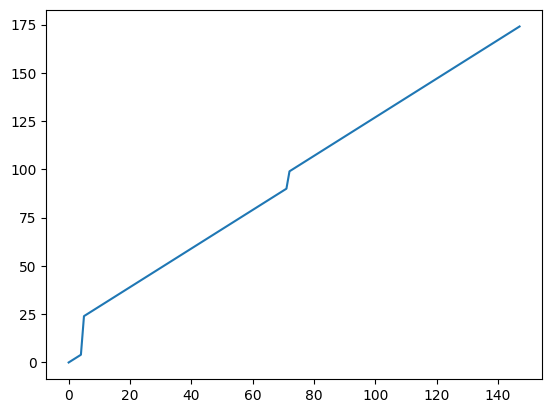

In [9]:
plt.plot(host_neumann) #! is always continuous

In [10]:
@cuda.jit
def kernel_face_gradient_2d(w_c:'float[:]', w_ghost:'float[:]', w_halo:'float[:]', w_node:'float[:]', cellidf:'int32[:,:]', 
                     nodeidf:'int32[:,:]', centergf:'float[:,:]', halofid:'int32[:]', centerc:'float[:,:]', 
                     centerh:'float[:,:]', vertexn:'float[:,:]', airDiamond:'float[:]', normalf:'float[:,:]',
                     f_1:'float[:,:]', f_2:'float[:,:]', f_3:'float[:,:]', f_4:'float[:,:]', shift:'float[:,:]', 
                     wx_face:'float[:]', wy_face:'float[:]', wz_face:'float[:]', innerfaces:'uint32[:]', halofaces:'uint32[:]',
                     dirichletfaces:'uint32[:]', neumann:'uint32[:]', periodicfaces:'uint32[:]'):
  idx = cuda.grid(1)

  if idx < innerfaces.shape[0]:
    i = innerfaces[idx]
    c_left = cellidf[i][0]
    c_right = cellidf[i][1]
        
    i_1 = nodeidf[i][0]
    i_2 = nodeidf[i][1]
    
    vi1 = w_node[i_1]
    vi2 = w_node[i_2]
    vv1 = w_c[c_left]
    vv2 = w_c[c_right]
    
    wx_face[i] = 1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
    wy_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])

  if idx < periodicfaces.shape[0]: 
    i = periodicfaces[idx]
    c_left = cellidf[i][0]
    c_right = cellidf[i][1]
        
    i_1 = nodeidf[i][0]
    i_2 = nodeidf[i][1]
    
    vi1 = w_node[i_1]
    vi2 = w_node[i_2]
    vv1 = w_c[c_left]
    vv2 = w_c[c_right]
    
    wx_face[i] = 1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
    wy_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])

  if idx < halofaces.shape[0]:
    i = halofaces[idx]
    c_left = cellidf[i][0]
    c_right = halofid[i]
    
    i_1 = nodeidf[i][0]
    i_2 = nodeidf[i][1]
    
    vi1 = w_node[i_1]
    vi2 = w_node[i_2]
    vv1 = w_c[c_left]
    vv2 = w_halo[c_right]
    
    wx_face[i] = 1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
    wy_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])

  
  if idx < dirichletfaces.shape[0]:
    i = dirichletfaces[idx]
    c_left = cellidf[i][0]
    c_right = i
    
    i_1 = nodeidf[i][0]
    i_2 = nodeidf[i][1]
    
    vi1 = w_node[i_1]
    vi2 = w_node[i_2]
    vv1 = w_c[c_left]
    vv2 = w_ghost[c_right]

    wx_face[i] = 1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
    wy_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])

  
  if idx < neumann.shape[0]:    
    i = neumann[idx]
    c_left = cellidf[i][0]
    c_right = i
    
    i_1 = nodeidf[i][0]
    i_2 = nodeidf[i][1]
    
    vi1 = w_node[i_1]
    vi2 = w_node[i_2]
    vv1 = w_c[c_left]
    vv2 = w_ghost[c_right]

    wx_face[i] = 1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
    wy_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])


def cuda_face_gradient_2d():
  nb_element = len(d_innerfaces) + len(d_periodicfaces) + len(d_halofaces) + len(d_dirichletfaces) + len(d_neumann)
  nb_threads = 128
  nb_blocks = nb_element // 128 + 1
  
  kernel_face_gradient_2d[nb_blocks, nb_threads](
    d_w_c,
    d_w_ghost,
    d_w_halo,
    d_w_node,
    d_cellidf,
    d_nodeidf,
    d_centergf,
    d_halofid,
    d_centerc,
    d_centerh,
    d_vertexn,
    d_airDiamond,
    d_normalf,
    d_f_1,
    d_f_2,
    d_f_3,
    d_f_4,
    d_shift,
    d_wx_face,
    d_wy_face,
    d_wz_face,
    d_innerfaces,
    d_halofaces,
    d_dirichletfaces,
    d_neumann,
    d_periodicfaces,
  )
  cuda.synchronize()

#cuda_face_gradient_2d()
test_time(700, cuda_face_gradient_2d)

/home/aben-ham/anaconda3/envs/stage/lib/python3.8/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 20 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


4.90023 ms


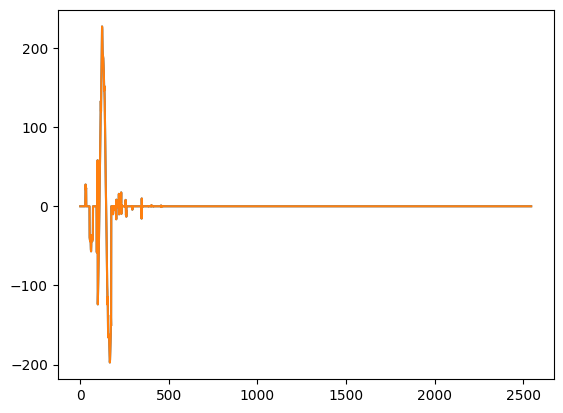

In [11]:
verify(host_wx_face, d_wx_face)

In [13]:
@cuda.jit
def kernel_face_gradient_2d(w_c:'float[:]', w_ghost:'float[:]', w_halo:'float[:]', w_node:'float[:]', cellidf:'int32[:,:]', 
                     nodeidf:'int32[:,:]', centergf:'float[:,:]', halofid:'int32[:]', centerc:'float[:,:]', 
                     centerh:'float[:,:]', vertexn:'float[:,:]', airDiamond:'float[:]', normalf:'float[:,:]',
                     f_1:'float[:,:]', f_2:'float[:,:]', f_3:'float[:,:]', f_4:'float[:,:]', shift:'float[:,:]', 
                     wx_face:'float[:]', wy_face:'float[:]', wz_face:'float[:]', innerfaces:'uint32[:]', halofaces:'uint32[:]',
                     dirichletfaces:'uint32[:]', neumann:'uint32[:]', periodicfaces:'uint32[:]'):
  i = cuda.grid(1)

  if innerfaces.shape[0] > 0 and i >= innerfaces[0] and i <= innerfaces[-1]:  
    c_left = cellidf[i][0]
    c_right = cellidf[i][1]
        
    i_1 = nodeidf[i][0]
    i_2 = nodeidf[i][1]
    
    vi1 = w_node[i_1]
    vi2 = w_node[i_2]
    vv1 = w_c[c_left]
    vv2 = w_c[c_right]
    
    wx_face[i] = 1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
    wy_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])


def cuda_face_gradient_2d():
  nb_element = len(d_innerfaces)
  nb_threads = 128
  nb_blocks = nb_element // 128 + 1
  
  kernel_face_gradient_2d[nb_blocks, nb_threads](
    d_w_c,
    d_w_ghost,
    d_w_halo,
    d_w_node,
    d_cellidf,
    d_nodeidf,
    d_centergf,
    d_halofid,
    d_centerc,
    d_centerh,
    d_vertexn,
    d_airDiamond,
    d_normalf,
    d_f_1,
    d_f_2,
    d_f_3,
    d_f_4,
    d_shift,
    d_wx_face,
    d_wy_face,
    d_wz_face,
    d_innerfaces,
    d_halofaces,
    d_dirichletfaces,
    d_neumann,
    d_periodicfaces,
  )
  cuda.synchronize()

#cuda_face_gradient_2d()
test_time(700, cuda_face_gradient_2d)

1.72324 ms


In [44]:
host_lim = max(host_innerfaces) + 1
host_arr_vi1 = np.empty(host_lim)
host_arr_vi2 = np.empty(host_lim)
host_arr_vv1 = np.empty(host_lim)
host_arr_vv2 = np.empty(host_lim)

for i in host_innerfaces:
  c_left = host_cellidf[i][0]
  c_right = host_cellidf[i][1]
      
  i_1 = host_nodeidf[i][0]
  i_2 = host_nodeidf[i][1]

  
  host_arr_vi1[i] = host_w_node[i_1]
  host_arr_vi2[i] = host_w_node[i_2]
  host_arr_vv1[i] = host_w_c[c_left]
  host_arr_vv2[i] = host_w_c[c_right]

d_arr_vi1 = cuda.to_device(host_arr_vi1)
d_arr_vi2 = cuda.to_device(host_arr_vi2)
d_arr_vv1 = cuda.to_device(host_arr_vv1)
d_arr_vv2 = cuda.to_device(host_arr_vv2)



In [45]:
@cuda.jit
def kernel_face_gradient_2d(w_c:'float[:]', w_ghost:'float[:]', w_halo:'float[:]', w_node:'float[:]', cellidf:'int32[:,:]', 
                     nodeidf:'int32[:,:]', centergf:'float[:,:]', halofid:'int32[:]', centerc:'float[:,:]', 
                     centerh:'float[:,:]', vertexn:'float[:,:]', airDiamond:'float[:]', normalf:'float[:,:]',
                     f_1:'float[:,:]', f_2:'float[:,:]', f_3:'float[:,:]', f_4:'float[:,:]', shift:'float[:,:]', 
                     wx_face:'float[:]', wy_face:'float[:]', wz_face:'float[:]', innerfaces:'uint32[:]', halofaces:'uint32[:]',
                     dirichletfaces:'uint32[:]', neumann:'uint32[:]', periodicfaces:'uint32[:]',
                     arr_vi1:'float[:]', arr_vi2:'float[:]', arr_vv1:'float[:]', arr_vv2:'float[:]', lim):
  i = cuda.grid(1)

  if i >= lim:
    return
  
  vi1 = arr_vi1[i]
  vi2 = arr_vi2[i]
  vv1 = arr_vv1[i]
  vv2 = arr_vv2[i]

  
  wx_face[i] = 1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][1] + (vv1 + vi2)*f_2[i][1] + (vi2 + vv2)*f_3[i][1] + (vv2 + vi1)*f_4[i][1])
  wy_face[i] = -1/(2*airDiamond[i])*((vi1 + vv1)*f_1[i][0] + (vv1 + vi2)*f_2[i][0] + (vi2 + vv2)*f_3[i][0] + (vv2 + vi1)*f_4[i][0])


def cuda_face_gradient_2d():
  nb_element = host_lim
  nb_threads = 128
  nb_blocks = nb_element // 128 + 1
  
  kernel_face_gradient_2d[nb_blocks, nb_threads](
    d_w_c,
    d_w_ghost,
    d_w_halo,
    d_w_node,
    d_cellidf,
    d_nodeidf,
    d_centergf,
    d_halofid,
    d_centerc,
    d_centerh,
    d_vertexn,
    d_airDiamond,
    d_normalf,
    d_f_1,
    d_f_2,
    d_f_3,
    d_f_4,
    d_shift,
    d_wx_face,
    d_wy_face,
    d_wz_face,
    d_innerfaces,
    d_halofaces,
    d_dirichletfaces,
    d_neumann,
    d_periodicfaces,
    d_arr_vi1,
    d_arr_vi2,
    d_arr_vv1,
    d_arr_vv2,
    host_lim
  )
  cuda.synchronize()

#cuda_face_gradient_2d()
test_time(700, cuda_face_gradient_2d)

2.77200 ms


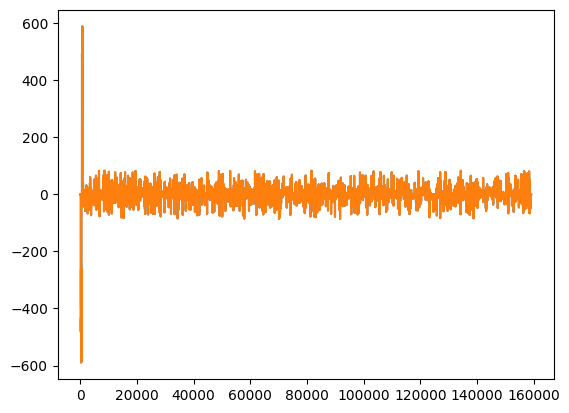

In [17]:
def verify(a, b):
  b = b.copy_to_host()
  plt.plot(a)
  plt.plot(b)

  #assert
  np.testing.assert_almost_equal(a, b, decimal=2, )
  plt.show()

verify(host_wx_face, d_wx_face)